In [13]:
import pandas as pd
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding
from sklearn.model_selection import train_test_split
import numpy as np
from keras import models
from keras.layers import Dropout, Bidirectional
from keras import metrics
from imblearn.over_sampling import SMOTE

In [14]:


# Load the dataset
data = pd.read_csv('train.csv')

# Preprocessing
data['tweet'] = data['tweet'].str.lower()  # Convert to lowercase
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tweet'])
sequences = tokenizer.texts_to_sequences(data['tweet'])
word_index = tokenizer.word_index

# Train a Word2Vec model








Word2Vec

In [ ]:
w2v_model = Word2Vec(sequences, window=5, min_count=1, workers=4)
w2v_model.save("word2vec.model")

# Prepare the embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    try:
        embedding_vector = w2v_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except KeyError:
        continue

GloVE

In [22]:
embeddings_index = {}
with open('glove.twitter.27B.100d.txt', 'r',  encoding='utf-8') as f:  
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


embedding_matrix = np.zeros((len(word_index) + 1, 100))  # assuming 100-dimensional embeddings
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector



In [25]:

# Prepare the data
X = pad_sequences(sequences)
y = data['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Define the model
from keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Define the model
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(64)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Change the number of units to the number of classes

# Compile the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=[
                  metrics.CategoricalAccuracy(name='accuracy'),
                  metrics.AUC(name='auc', multi_label=True),
              ])

# Train the model with the oversampled data







In [16]:



# Define the oversampling strategy
smote = SMOTE(sampling_strategy='auto')

# Fit and apply the transform
X_over, y_over = smote.fit_resample(X_train, y_train)
class_labels = {0: 'hate speech', 1: 'offensive language', 2: 'neither'}

# Print some examples from the original training data
print("Original training data:")
for i in np.random.choice(X_train.shape[0], 10):
    print(f'Tweet: {tokenizer.sequences_to_texts([X_train[i]])[0]}')
    print(f'Class: {class_labels[y_train[i]]}')
    print('---')

# Print some examples from the oversampled training data
print("\nOversampled training data:")
for i in np.random.choice(X_over.shape[0], 10):
    print(f'Tweet: {tokenizer.sequences_to_texts([X_over[i]])[0]}')
    print(f'Class: {class_labels[y_over[i]]}')
    print('---')






Original training data:
Tweet: rt dandanmanlyman 00sexilexi00 swiggety swag i love you too fag
Class: offensive language
---
Tweet: 8220 therealiman no one wants to see curvy women karl lagerfeld 8221 he retarded
Class: offensive language
---
Tweet: rt lemarquand jihadi in chief hussein urges restraint in fighting islamic butchers 8252 65039 apparently we should be nice to isis we might hurt 8230
Class: neither
---
Tweet: rt iamtahyi tho i hate when bitches twerk to slow songs 128530 128074 128162
Class: offensive language
---
Tweet: yo bitch all over me i ain't make no commitment
Class: offensive language
---
Tweet: jones and iba 241 ez are out of gas after giving it their all earlier in the first half the call ups should get more playing time yankees mlb
Class: neither
---
Tweet: stop lettin them messy hoes mess with your business
Class: offensive language
---
Tweet: rt friendlyassh0le these 13 yr old bitches really got that minimum wage nigga alex thinking about starting a clothing 

In [26]:
# Train the model with the oversampled data
#model.fit(X_over, y_over, validation_data=(X_test, y_test), epochs=10)
#model.fit(X_over, y_over, validation_data=(X_test, y_test_one_hot), epochs=10)
model.fit(X_train, y_train_one_hot, validation_data=(X_test, y_test_one_hot), epochs=10)

# Save the model
model.save('model_CCE.keras')


Epoch 1/10
620/620 [==============================] - 89s 136ms/step - loss: 0.3342 - accuracy: 0.8841 - auc: 0.8893 - val_loss: 0.2697 - val_accuracy: 0.9016 - val_auc: 0.9284
Epoch 2/10
620/620 [==============================] - 83s 133ms/step - loss: 0.2539 - accuracy: 0.9102 - auc: 0.9343 - val_loss: 0.2568 - val_accuracy: 0.9090 - val_auc: 0.9371
Epoch 3/10
620/620 [==============================] - 104s 168ms/step - loss: 0.2357 - accuracy: 0.9152 - auc: 0.9434 - val_loss: 0.2450 - val_accuracy: 0.9143 - val_auc: 0.9416
Epoch 4/10
620/620 [==============================] - 117s 189ms/step - loss: 0.2200 - accuracy: 0.9203 - auc: 0.9510 - val_loss: 0.2757 - val_accuracy: 0.9032 - val_auc: 0.9394
Epoch 5/10
620/620 [==============================] - 111s 178ms/step - loss: 0.2039 - accuracy: 0.9266 - auc: 0.9585 - val_loss: 0.2579 - val_accuracy: 0.9122 - val_auc: 0.9391
Epoch 6/10
620/620 [==============================] - 114s 184ms/step - loss: 0.1917 - accuracy: 0.9284 - auc: 0

155/155 [==============================] - 11s 59ms/step - loss: 0.3661 - accuracy: 0.9076 - auc: 0.9075
Test Accuracy: 90.76054096221924
Test AUC: 90.75091481208801
155/155 [==============================] - 6s 31ms/step
Tweet: wish they'd teach tracee rt kanyebreast all chihuahuas do that squinty eye shit i think it's hilarious
True class: offensive language
Predicted class: offensive language
---
Tweet: rt pumpkinheaddd 128530 why these hoes acting like they not getting fucked amp sucking dick 128080 but i ain't saying nothing 128520
True class: offensive language
Predicted class: offensive language
---
Tweet: lmfaoooooo rt toodopeforlife lmfaooooooopoooooo rt djkayyohh 8220 here come yo bitch ass auntie 8221 http t co e5kllhp0cv
True class: offensive language
Predicted class: offensive language
---
Tweet: so yesterday i ran into a dude i went to high school with amp he used to be skinny as hell now omg same fucker who slit my tires years ago
True class: offensive language
Predicted

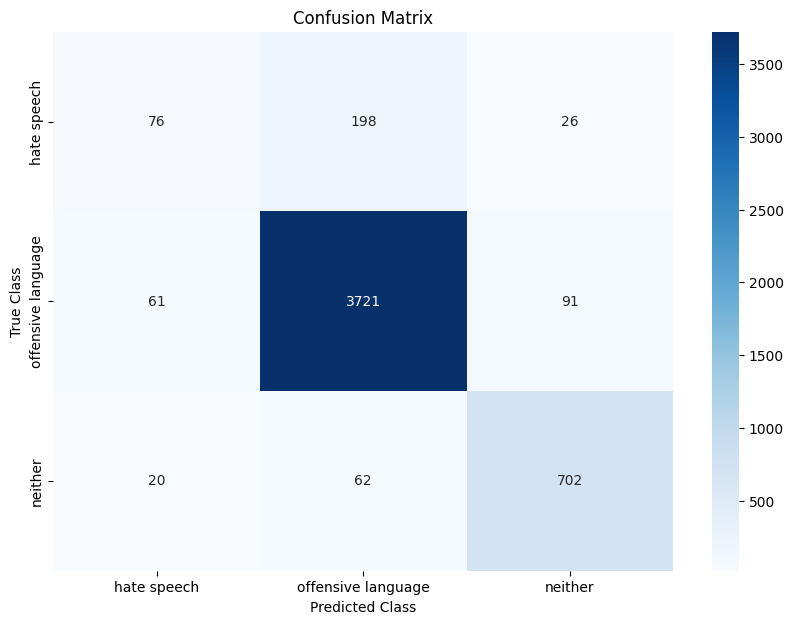

In [51]:
model =models.load_model('model_CCE.keras')
# Evaluate the model
loss, accuracy, auc = model.evaluate(X_test, y_test_one_hot)
print(f'Test Accuracy: {accuracy*100}')

print(f'Test AUC: {auc*100}')

# Predict the classes of the test data
# Predict the probabilities of the test data
y_pred_probs = model.predict(X_test)

# Convert the probabilities to class labels
y_pred = y_pred_probs.argmax(axis=-1)

# Define a dictionary that maps each encoded class to its original label
class_labels = {0: 'hate speech', 1: 'offensive language', 2: 'neither'}

# Print some examples from the test data
for i in range(10):
    print(f'Tweet: {tokenizer.sequences_to_texts([X_test[i]])[0]}')
    print(f'True class: {class_labels[y_test[i]]}')
    print(f'Predicted class: {class_labels[y_pred[i]]}')
    print('---')


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define the labels of the confusion matrix
labels = ['hate speech', 'offensive language', 'neither']

# Create a DataFrame for the confusion matrix for better visualization
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()




In [50]:
# Define your example tweet
example_tweet = "birds and bees"

# Preprocess the tweet
example_sequence = tokenizer.texts_to_sequences([example_tweet])
example_padded_sequence = pad_sequences(example_sequence, maxlen=X_test.shape[1])

# Predict the class of the example tweet
example_pred_probs = model.predict(example_padded_sequence)
example_pred = example_pred_probs.argmax(axis=-1)

# Print the predicted class
print(f'Predicted class: {class_labels[example_pred[0]]}')


1/1 [==============================] - 0s 34ms/step
Predicted class: neither
